In [1]:
import re

import numpy as np
import pandas as pd

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('../../../input/2016 School Explorer.csv')
df2 = pd.read_csv('../../../input/D5 SHSAT Registrations and Testers.csv')

In [3]:
df1_copy = df1.copy()
df2_copy = df2.copy()

In [4]:
for col in df1_copy.columns.values:
    print col

Adjusted Grade
New?
Other Location Code in LCGMS
School Name
SED Code
Location Code
District
Latitude
Longitude
Address (Full)
City
Zip
Grades
Grade Low
Grade High
Community School?
Economic Need Index
School Income Estimate
Percent ELL
Percent Asian
Percent Black
Percent Hispanic
Percent Black / Hispanic
Percent White
Student Attendance Rate
Percent of Students Chronically Absent
Rigorous Instruction %
Rigorous Instruction Rating
Collaborative Teachers %
Collaborative Teachers Rating
Supportive Environment %
Supportive Environment Rating
Effective School Leadership %
Effective School Leadership Rating
Strong Family-Community Ties %
Strong Family-Community Ties Rating
Trust %
Trust Rating
Student Achievement Rating
Average ELA Proficiency
Average Math Proficiency
Grade 3 ELA - All Students Tested
Grade 3 ELA 4s - All Students
Grade 3 ELA 4s - American Indian or Alaska Native
Grade 3 ELA 4s - Black or African American
Grade 3 ELA 4s - Hispanic or Latino
Grade 3 ELA 4s - Asian or Pacific

In [5]:
for col in df2_copy.columns.values:
    print col

DBN
School name
Year of SHST
Grade level
Enrollment on 10/31
Number of students who registered for the SHSAT
Number of students who took the SHSAT


In [6]:
remove = ['Other Location Code in LCGMS', 'Adjusted Grade', 'New?']
df1_copy = df1_copy.drop(columns=remove)

In [7]:
df1_copy['IsCommunitySchool'] = df1_copy['Community School?'] == 'Yes'
df1_copy = df1_copy.drop(columns=['Community School?'])

In [8]:
percent_pattern = r'Percent\s.*'
percent_regex = re.compile(percent_pattern, re.IGNORECASE)

for col in df1_copy.columns.values:
    if percent_regex.search(col):
        print col
        df1_copy[col] = df1_copy[col].astype(np.object).str.replace('%', '').astype(float)
df1_copy['School Income Estimate'] = df1_copy['School Income Estimate'].astype(np.object).str.replace('$', '').str.replace(',', '').str.replace('.', '').astype(float)
df1_copy['Student Attendance Rate'] = df1_copy['Student Attendance Rate'].astype(np.object).str.replace('%', '').astype(float)
df1_copy['Percent of Students Chronically Absent'] = df1_copy['Percent of Students Chronically Absent'].astype(np.object).str.replace('%', '').astype(float)

Percent ELL
Percent Asian
Percent Black
Percent Hispanic
Percent Black / Hispanic
Percent White
Percent of Students Chronically Absent


In [9]:
df1_copy['School Name'] = df1_copy['School Name'].astype(str)
df1_copy = df1_copy[df1_copy['Grade High'] != '0K']
df1_copy['Grade High'] = df1_copy['Grade High'].astype(float)

In [10]:
df1_copy = df1_copy[df1_copy['Grade High'] > 5]

In [11]:
SPI_columns = ['Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %', 
               'Effective School Leadership %', 'Strong Family-Community Ties %', 'Trust %']
for col in SPI_columns:
    df1_copy[col] = df1_copy[col].astype(np.object).str.replace('%', '').astype(float)

In [12]:
school_rating = df1_copy[SPI_columns].dropna()
school_rating.corr()

,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
Rigorous Instruction %,1.000000,0.757568,0.720514,0.643093,0.540730,0.708931
Collaborative Teachers %,0.757568,1.000000,0.594114,0.915435,0.485351,0.882959
Supportive Environment %,0.720514,0.594114,1.000000,0.488354,0.581007,0.714141
Effective School Leadership %,0.643093,0.915435,0.488354,1.000000,0.444356,0.853213
Strong Family-Community Ties %,0.540730,0.485351,0.581007,0.444356,1.000000,0.588877
Trust %,0.708931,0.882959,0.714141,0.853213,0.588877,1.000000


<h2> Weights to each factor </h2>

* 1.0 Supportive Environment % (Supportive Environment Rating)
* 0.8 Rigorous Instruction % (Rigorous Instruction Rating)
* 0.7 Effective School Leadership % (Effective School Leadership Rating)
* 0.5 Strong Family-Community Ties % (Strong Family-Community Ties Rating)

Dropping the following columns due to high correlation with other columns : 
* Collaborative Teachers % (Collaborative Teachers Rating)
* Trust % (Trust Rating)

In [13]:
df1_copy['SPI'] = df1_copy['Supportive Environment %'] \
                + 0.8 * df1_copy['Rigorous Instruction %'] \
                + 0.7 * df1_copy['Effective School Leadership %'] \
                + 0.5 * df1_copy['Strong Family-Community Ties %']

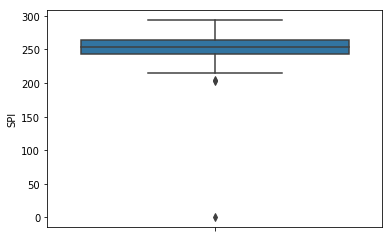

In [14]:
sns.boxplot(y='SPI', data=df1_copy)

<h3> Look at the lowest quartile of SPI. Analyse these schools </h3>

In [15]:
poor_schools = df1_copy[df1_copy['SPI'] < 243.55]
print "Number of poor schools: " + str(len(poor_schools))

poor_schools_sorted = poor_schools.sort_values('SPI')

Number of poor schools: 155


In [16]:
df1_copy[['Economic Need Index', 'SPI']+SPI_columns].corr()['Economic Need Index']

Economic Need Index               1.000000
SPI                              -0.162383
Rigorous Instruction %           -0.192186
Collaborative Teachers %         -0.151899
Supportive Environment %         -0.138638
Effective School Leadership %    -0.137282
Strong Family-Community Ties %   -0.035330
Trust %                          -0.083415
Name: Economic Need Index, dtype: float64

In [17]:
df1_copy['Percent Black']

3       29.0
8       13.0
10       4.0
11      30.0
12      26.0
13      29.0
15      27.0
19      22.0
20      21.0
21       9.0
22      16.0
36       8.0
38       3.0
41      11.0
43       8.0
47       8.0
48      11.0
52      16.0
53      19.0
55       3.0
56       6.0
58       4.0
59       8.0
61       2.0
63      22.0
64       3.0
65      16.0
66      23.0
67      11.0
68      19.0
        ... 
1226    40.0
1227    54.0
1228    35.0
1229    43.0
1230    58.0
1232    40.0
1233    35.0
1235    44.0
1237    19.0
1239    34.0
1241    48.0
1243    29.0
1247    29.0
1250    44.0
1251    62.0
1252    21.0
1253    40.0
1254     7.0
1255    32.0
1257    73.0
1259    34.0
1260    56.0
1261    63.0
1262    61.0
1263    56.0
1265    50.0
1266    40.0
1268    68.0
1269    54.0
1271    28.0
Name: Percent Black, Length: 626, dtype: float64

Text(0.5,0,'Longitude')

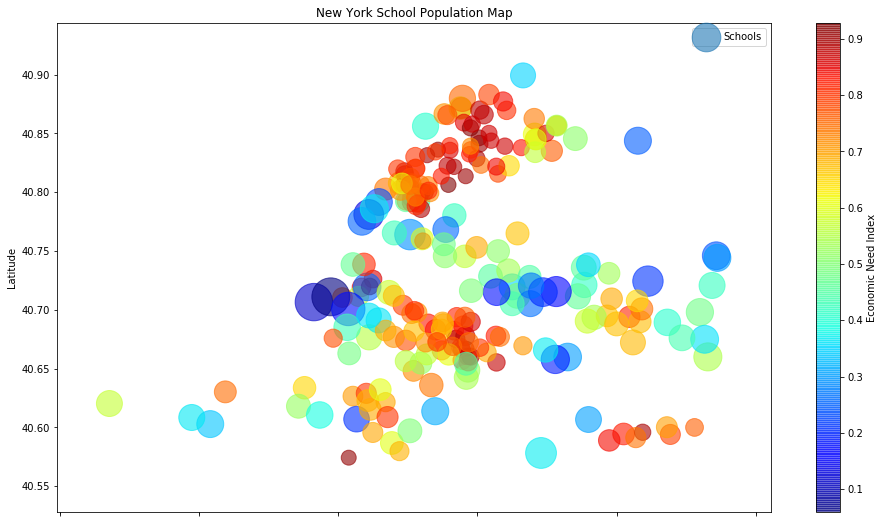

In [18]:
ax = df1_copy.plot(kind="scatter", x="Longitude", y="Latitude", 
                   s=df1_copy['School Income Estimate']/10000, c="Economic Need Index", cmap=plt.get_cmap("jet"), 
                   label='Schools', title='New York School Population Map', 
                   colorbar=True, alpha=0.6, figsize=(16,9))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

Text(0.5,0,'Longitude')

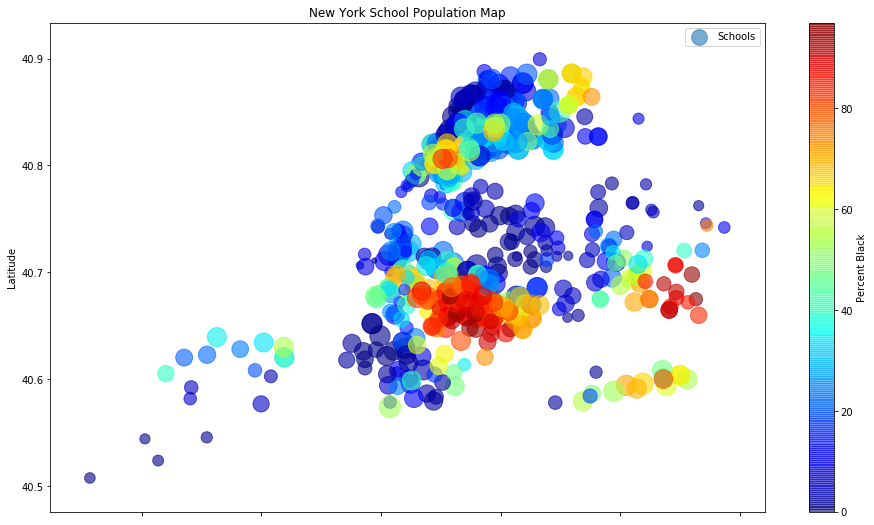

In [19]:
ax = df1_copy.plot(kind="scatter", x="Longitude", y="Latitude", 
                   s=df1_copy['Economic Need Index']*500, c="Percent Black", cmap=plt.get_cmap("jet"), 
                   label='Schools', title='New York School Population Map', 
                   colorbar=True, alpha=0.6, figsize=(16,9))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

/home/eddie7/kaggleprojects/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


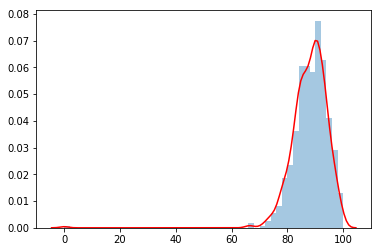

In [41]:
sns.distplot(a=df1_copy['Rigorous Instruction %'].dropna().values, kde_kws={"color": "red"})

['Rigorous Instruction %',
 'Collaborative Teachers %',
 'Supportive Environment %',
 'Effective School Leadership %',
 'Strong Family-Community Ties %',
 'Trust %',
 'SPI']

In [22]:
# ax = df1_copy.plot(kind="scatter", x="Longitude", y="Latitude", 
#                    s=df1_copy['Economic Need Index']*100, c='SPI', cmap=plt.get_cmap("jet"), 
#                    label='Schools', title='New York School Population Map', 
#                    colorbar=True, alpha=0.6, figsize=(16,9))
# ax.set_ylabel('Latitude')
# ax.set_xlabel('Longitude')

In [23]:
from sklearn.cluster import KMeans

In [24]:
df1_copy_copy = df1_copy.copy()
df1_copy_copy = df1_copy_copy.dropna(subset=['Longitude', 'Latitude'])
df1_copy_copy = df1_copy_copy[df1_copy_copy['SPI'] < 243.55]
df1_copy_copy = df1_copy_copy[df1_copy_copy['Economic Need Index'] > 0.6]

In [25]:
model = KMeans(n_clusters=7)
model.fit(df1_copy_copy[['Longitude', 'Latitude']].values)
model.cluster_centers_
color = 'blue'

In [26]:
df1_copy_copy['Cluster'] = model.predict(df1_copy_copy[['Longitude', 'Latitude']].values)

In [27]:
school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
for row in model.cluster_centers_:
    folium.Marker([row[1], row[0]], icon=folium.Icon(color='gray')).add_to(school_map)
for index in df1_copy_copy.index:
    row = df1_copy_copy.loc[index]
    if row['Economic Need Index'] > 0.6 and row['SPI'] < 243.55:
        popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
        folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)


school_map

<h2> Analyse the registrations and test takers in schools that are performing poorly </h2>

In [28]:
# df2_copy['Took Percentage'] = df2_copy['Number of students who took the SHSAT'] / df2_copy['Number of students who registered for the SHSAT']

In [29]:
# df2_copy

In [30]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))
# sns.barplot(y='School name', x='Took Percentage', data=df2_copy, hue='Grade level', ax=ax[0], ci=None, orient='h')
# sns.barplot(y='School name', x='Took Percentage', data=df2_copy, hue='Year of SHST', ax=ax[1], ci=None, orient='h')

# for ax in fig.axes:
#     plt.sca(ax)
#     plt.yticks(rotation=45)

# fig.tight_layout()

In [31]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))
# sns.barplot(x='School name', y='Number of students who registered for the SHSAT', data=df2_copy, ax=ax[0], ci=None)
# sns.barplot(x='School name', y='Number of students who took the SHSAT', data=df2_copy, ax=ax[1], ci=None)

# for ax in fig.axes[:-1]:
#     plt.sca(ax)
#     plt.xticks([])
# plt.sca(fig.axes[-1])
# plt.xticks(rotation=90)

# fig.tight_layout()

In [32]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
# sns.barplot(x='School name', y='Took Percentage', data=df2_copy, ax=ax, ci=None)
# plt.xticks(rotation=90)